In [55]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy.signal import argrelextrema
import os

import sys
sys.path.append('../../')
from cad.calc.geo import Geo
from cad.calc.conv import freq_to_note_and_cent, note_name
import pandas as pd
import seaborn as sns
from sklearn import svm
from scipy.signal import argrelextrema

import json

def do_fft(infile, maxfreq=1000):
    sampFreq, sound = wavfile.read(infile)
    
    if len(sound.shape)==2:
        signal = sound[:,0]
    else:
        signal = sound

    size=len(signal)
    
    fft_spectrum = np.fft.rfft(signal, n=size)
    freq = np.fft.rfftfreq(size, d=1./sampFreq)
    fft_spectrum_abs = np.abs(fft_spectrum)
 
    i=0
    while i<len(freq) and freq[i]<=maxfreq:
        i+=1
    freq = freq[0:i]
    fft_spectrum_abs = fft_spectrum_abs[0:i]
    #fft_spectrum_abs = np.log2(fft_spectrum_abs)

    return freq, fft_spectrum_abs

def get_harmonic_maxima(freq, spectrum, min_freq=60):
    i=0
    maxima = []
    base_freq = min_freq
    while i*base_freq<1000:
        if i==0:
            window = freq>min_freq
        else:
            window = (freq>(i+0.5)*base_freq) & (freq<base_freq*(i+1.5))

        if window.astype(int).sum() == 0:
            break
        window_f = freq[window]
        window_s = spectrum[window]
        maxi = np.argmax(window_s)
        max_f = window_f[maxi]
        if i==0:
            base_freq=max_f

        maxima.append(max_f)
        i+=1
    return maxima

# compute rms error of two ragged lists
# will be normalized by the length of each sublist and the number of ragged lists
def rms_error(measured_maxima, computed_maxima):
    error = 0
    for i in range(len(measured_maxima)):
        y = np.array(measured_maxima[i]) - np.array(computed_maxima[i])
        y = np.power(y, 2).sum()
        y = np.sqrt(y) / len(measured_maxima[i])
        error += y
    error /= len(measured_maxima)
    return error

archive_path_json = "../../../../didge-archive/didge-archive.json"
archive_path = os.path.dirname(archive_path_json)
archive = json.load(open(archive_path_json, "r"))

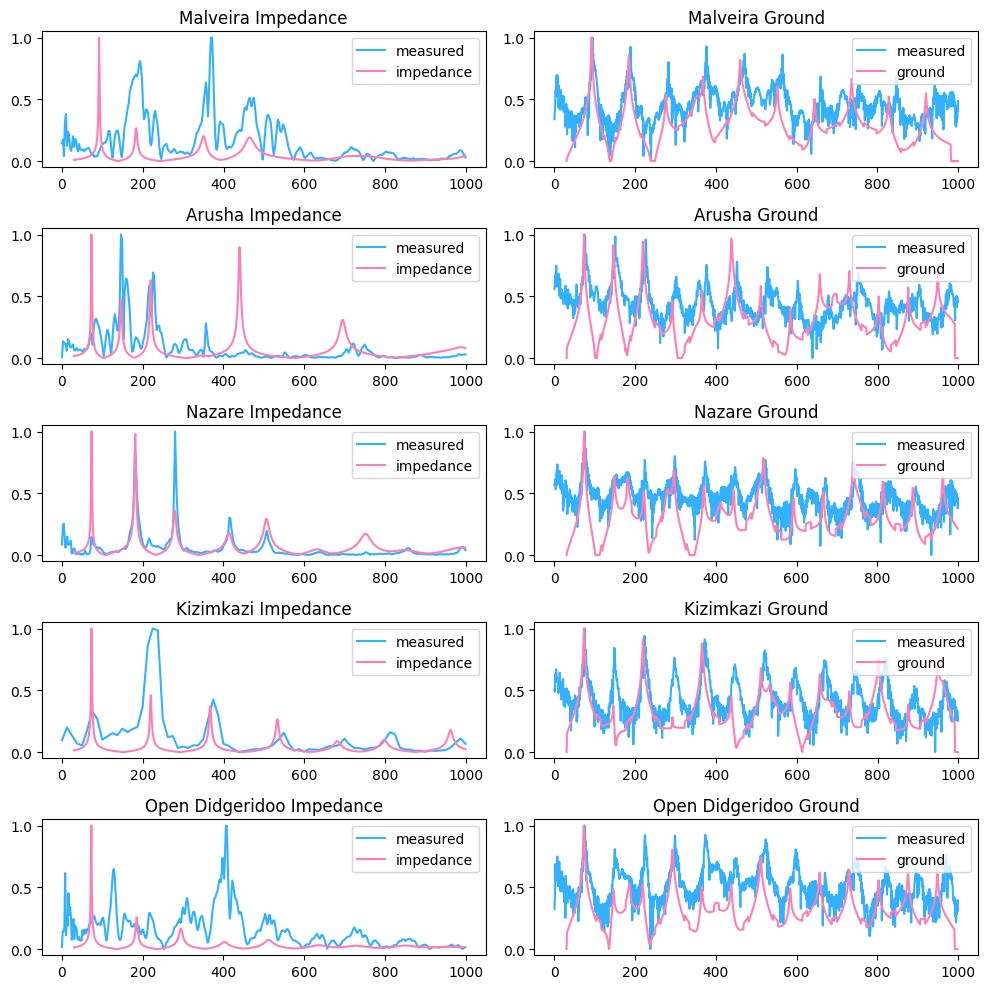

In [88]:
archive_path_json = "../../../../didge-archive/didge-archive.json"
archive_path = os.path.dirname(archive_path_json)
archive = json.load(open(archive_path_json, "r"))
colors = ['#8a3ffc', '#33b1ff', '#007d79', '#ff7eb6', '#fa4d56', '#fff1f1', '#6fdc8c', '#4589ff', '#d12771', '#d2a106', '#08bdba', '#bae6ff', '#ba4e00', '#d4bbff']

def paint_maxima(x, y, color, method="harmonic"):
    if method=="harmonic":
        maxima = get_harmonic_maxima(x,y)
    elif method=="local":
        maxima_i = argrelextrema(np.array(y), np.greater)
        maxima = x[maxima_i]
    else:
        raise Exception()

    for m in maxima:
        plt.axvline(m, color=color)
    return maxima


def plot_impedance(ax, didge):

    geo = json.load(open(os.path.join(archive_path, didge["geometry"]), "r"))
    geo = Geo(geo)
    cadsd = geo.get_cadsd()

    spektrum=cadsd.get_ground_spektrum()
    ground_freq = np.array(list(spektrum.keys()))
    ground_vols = np.array(list(spektrum.values()))
    ground_vols -= ground_vols.min()
    ground_vols /= ground_vols.max()

    #paint_maxima(ground_freq, ground_vols, colors[0])
    #plt.plot(ground_freq, ground_vols, label="computed", color=colors[0])

    sound_file = os.path.join(archive_path, didge["audio-samples"]["hand-closed"])
    #sound_file = os.path.join(archive_path, "audio-samples/kizimkazi-hand2.wav")

    freq, spectrum = do_fft(sound_file)
    #spectrum = np.log2(spectrum)
    spectrum -= spectrum.min()
    spectrum /= spectrum.max()
    spectrum = np.exp(spectrum)
    #spectrum = np.exp(spectrum)
    #spectrum = np.exp(spectrum)
    spectrum -= spectrum.min()
    spectrum /= spectrum.max()
    
    ax.plot(freq, spectrum, label="measured", color=colors[1])
    #paint_maxima(freq, spectrum, colors[1])

    imp = cadsd.get_impedance_spektrum()
    impedance = imp.impedance
    impedance -= impedance.min()
    impedance /= impedance.max()

    ax.plot(imp.freq, impedance, label="impedance", color=colors[3])
    #imp_maxima = paint_maxima(np.array(imp.freq), impedance, colors[3], method="local")

    ax.legend()
    name = didge["name"] + " Impedance"
    ax.set_title(name)

def plot_ground(ax, didge):

    geo = json.load(open(os.path.join(archive_path, didge["geometry"]), "r"))
    geo = Geo(geo)
    cadsd = geo.get_cadsd()

    spektrum=cadsd.get_ground_spektrum()
    ground_freq = np.array(list(spektrum.keys()))
    ground_vols = np.array(list(spektrum.values()))
    ground_vols -= ground_vols.min()
    ground_vols /= ground_vols.max()

    #paint_maxima(ground_freq, ground_vols, colors[0])
    #plt.plot(ground_freq, ground_vols, label="computed", color=colors[0])

    sound_file = os.path.join(archive_path, didge["audio-samples"]["neutral-sound"])
    #sound_file = os.path.join(archive_path, "audio-samples/kizimkazi-hand2.wav")

    freq, spectrum = do_fft(sound_file)
    spectrum = np.log2(spectrum)
    spectrum -= spectrum.min()
    spectrum /= spectrum.max()
    
    ax.plot(freq, spectrum, label="measured", color=colors[1])
    #paint_maxima(freq, spectrum, colors[1])

    imp = cadsd.get_impedance_spektrum()
    impedance = imp.impedance
    impedance -= impedance.min()
    impedance /= impedance.max()

    ax.plot(ground_freq, ground_vols, label="ground", color=colors[3])
    #imp_maxima = paint_maxima(np.array(imp.freq), impedance, colors[3], method="local")

    ax.legend()
    name = didge["name"] + " Ground"
    ax.set_title(name)

    
fig, axs = plt.subplots(len(archive), 2, figsize=(10,10))
for i in range(len(archive)):
    plot_impedance(axs[i][0], archive[i])
    plot_ground(axs[i][1], archive[i])
    
fig.tight_layout()

In [69]:
sound_file = os.path.join(archive_path, didge["audio-samples"]["hand-closed"])
freq, spectrum = do_fft(sound_file)
np.exp(spectrum)

/var/folders/x2/b40hstxn35z830rfs3b1ncrc0000gp/T/ipykernel_56575/3293861611.py:3: RuntimeWarning: overflow encountered in exp
  np.exp(spectrum)


array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf])

In [41]:
ls ../../../../didge-archive/audio-samples/

arusha-hand1.wav             malverira-hand1.wav
arusha-hand2.wav             nazare-hand1.wav
arusha-neutral-sound.wav     nazare-hand2.wav
arusha-short-song.wav        nazare-neutral-sound.wav
kizimkazi-hand1.wav          nazare-short-song.wav
kizimkazi-hand2.wav          open-didge-drags.wav
kizimkazi-neutral-sound.wav  opendidge-hand1.wav
kizimkazi-short-song.wav     opendidge-hand2.wav
malveira-hand2.wav           opendidge-neutral-sound.wav
malveira-neutral-sound.wav   opendidge-short-song.wav
malveira-short-song.wav


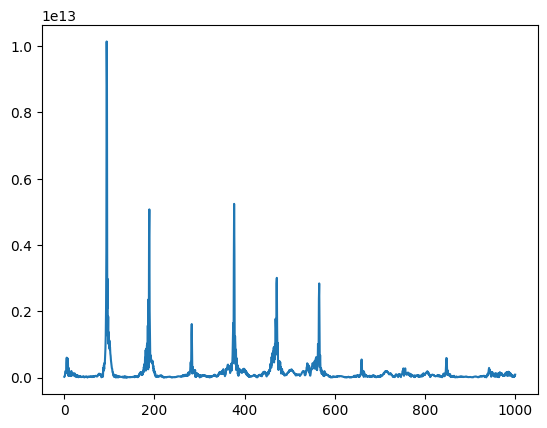

In [85]:
sound_file = os.path.join(archive_path, archive[0]["audio-samples"]["neutral-sound"])
freq, spectrum = do_fft(sound_file)
#spectrum = np.log2(spectrum)
#spectrum -= spectrum.min()
#spectrum /= spectrum.max()
plt.plot(freq, spectrum)